In [10]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

def simple_lin_interp(x1, y1, x2, y2, x):
    slope = (y2 - y1) / float(x2 - x1)
    return slope * (x - x1) + y1
def get_neighbor(DG, node):
    try:
        neighbors = DG.successors(DG.predecessors(node)[0])
    except:
        neighbors = []
    return neighbors
def return_smoothed(points, interpolate=False):
    if len(points) < 3: return points
    from scipy.interpolate import splrep
    from scipy.interpolate import splev
    from scipy.interpolate import Akima1DInterpolator

    x, y = zip(*points)

    if interpolate:
        return points
        # return zip(x,Akima1DInterpolator(x,y)(x))

    else:
        from statsmodels.nonparametric.kernel_regression import KernelReg
        kr = KernelReg(y, x, 'c')
        x_ = []  # list(np.linspace(min(x),max(x),3))
        x_.extend(x)
        x_ = sorted(set(x_))
        y_pred, _ = kr.fit(x_)

        return zip(x_, y_pred)


        if len(points) > 2:
            w = [1] + [0.1] * (len(points) - 2) + [1]
        else:
            w = [1] * len(points)

        K = min([len(points) - 1, 3])
        spl = splrep(x, y, s=30., t=[], k=K, w=w)
        # plt.figure()
        # plt.plot(x,splev(x,spl))
        # plt.plot(x,y,'o')
        # plt.show()
        x_ = []  # list(np.linspace(min(x),max(x),3))
        x_.extend(x)
        x_ = sorted(set(x_))
        return zip(x_, splev(x_, spl))
def nx_walk(node,tree,override_list=False):
    """ iterate tree in pre-order depth-first search order """
    if override_list is not False:
        for n in override_list:
            yield n
    else:
        yield node
        for child in tree.successors(node):
            for n in nx_walk(child,tree):
                yield n



def _make_phylo_cmap():
    import collections
    import random
    def shuffle(x):
        x = list(x)
        random.shuffle(x)
        return x

    def _get_fixed_colors(subclone_key):
        # green, black, blue,purple,orange

        color_list = [[39, 140, 24],
                      [103, 200, 243],
                      [16, 49, 41],
                      [248, 139, 16],
                      [93, 119, 254],
                      [152, 22, 26],
                      [104, 236, 172],
                      [249, 142, 135],
                      [55, 18, 48],
                      [83, 82, 22],
                      [247, 36, 36],
                      [0, 79, 114],
                      [243, 65, 132],
                      [60, 185, 179],
                      [185, 177, 243],
                      [139, 34, 67],
                      [178, 41, 186],
                      [58, 146, 231],
                      [130, 159, 21],
                      [161, 91, 243],
                      [131, 61, 17],
                      [248, 75, 81],
                      [32, 75, 32],
                      [45, 109, 116],
                      [255, 169, 199],
                      [55, 179, 113],
                      [34, 42, 3],
                      [56, 121, 166],
                      [172, 60, 15],
                      [115, 76, 204],
                      [21, 61, 73],
                      [67, 21, 74],  # Additional colors, uglier and bad
                      [123, 88, 112],
                      [87, 106, 46],
                      [37, 66, 58],
                      [132, 79, 62],
                      [71, 58, 32],
                      [59, 104, 114],
                      [46, 107, 90],
                      [84, 68, 73],
                      [90, 97, 124],
                      [121, 66, 76],
                      [104, 93, 48],
                      [49, 67, 82],
                      [71, 95, 65],
                      [127, 85, 44]]

        return color_list[subclone_key]

    palette = _get_fixed_colors(slice(None, None, None))

    # Scale the RGB values to the [0, 1] range,which is the format matplotlib accepts.
    for i in range(len(palette)):
        r, g, b = palette[i]
        palette[i] = (r / 255., g / 255., b / 255.)
    from matplotlib import colors as mcolors

    phylo_cmap = mcolors.ListedColormap(palette)
    return phylo_cmap


def get_child_color(parent_color,differentiate=False):

            if differentiate:

                child_color = [min([1, 0.5 * parent_color[x] + 0.5 * parent_color[x]]) for x in range(3)]
            else:
                child_color = [min([1, 0.5 *parent_color[x] + 0.5]) for x in range(3)]



class simple_tree():

    """
    Class to allow slicing points across intervals. Intended for large mafs.
    (works for 1d data, but not arbitrary length segments)
    Similar to a BST

    Built to work for int positions, but could be re-done to work

    """

    def __init__(self, _xvals=None, _data=None, sorted_=True):

        if (_data is not None) and (_xvals is not None):
            if sorted_:
                self._xvals = _xvals
                self._data = _data
            else:  # assume sorted, but if re-sorting is nessary do it.
                self._xvals, self._data = zip(*sorted(zip(_xvals, _data), key=lambda x: x[0]))
                self._xvals=list(self._xvals)
                self._data=list(self._data)
        else:
            self._xvals = []
            self._data = []

    def __len__(self):
        return len(self._data)

    def __repr__(self):
        return str(self._data)

    def __getitem__(self, sliced):
        if type(sliced) is int or type(sliced) is float:  # if the slice is a point, return the point
            return [self._xvals[bisect.bisect_left(self._xvals, sliced)], self._data[bisect.bisect_left(self._xvals, sliced)]]
        else:  # otherwise slice from the slice object with bisection
            return zip(self._xvals[bisect.bisect_left(self._xvals, sliced.start):bisect.bisect_left(self._xvals, sliced.stop)],
                       self._data[bisect.bisect_left(self._xvals, sliced.start):bisect.bisect_left(self._xvals, sliced.stop)])

    def add(self, item):
        """
        Add an item, assumes [pos(int),value]
        Append if not sorted, else binary search for position.
        """
        try:  # will throw index error on first attempt.

            _sorted = item[0] >= self._xvals[-1]
        except IndexError:
            _sorted = True  # it is slowish to check every time if the list exists or not, but on the first try it's going to give indexerror since it's empty.

        if _sorted:  # if item is at the end we can do O(1) append.
            self._xvals.append(item[0])
            self._data.append(item[1])

        else:  # if item is not at the end, we need  O(logN) binary search, then  O(N) insert. In all O(NlogN)

            ins_idx = bisect.bisect(self._xvals, item[0])
            self._xvals.insert(ins_idx, item[0])
            self._data.insert(ins_idx, item[1])

    def append(self, item):
        """
        Append an item, assumes [pos(int),value] and item belongs at end of list!
        """
        self._data.append(item[1])
        self._xvals.append(item[0])

    def copy(self):
        return simple_tree(_xvals=self._xvals[:], _data=self._data[:], sorted_=True)  # new tree, parameters should be default but might change.

    def _re_sort(self):
        """
        This function shouldn't need to be called. Re-sort the object.
        """
        self._xvals, self._data = zip(*sorted(zip(self._xvals, self._data), key=lambda x: x[0]))



def make_fish(cluster_raw_ccfs,graph=None, wbc=tuple(), add_wbc=simple_tree(), sample_labels=tuple(), times=tuple(), interp="smooth",smooth_hack=False,scatter=False):

    phylo_cmap = _make_phylo_cmap()

    # plt.figure(figsize=(20,4))
    import numpy as np
    import matplotlib.pyplot as plt






    n_timepoints = len(cluster_raw_ccfs[0])
    n_clusters= len(cluster_raw_ccfs)

    if len(wbc) == 0:
        wbc = np.repeat(1,n_timepoints)
    if len(times) == 0:
        times = list(range(1,n_timepoints+1))

    if len(add_wbc) == 0:
        add_wbc=simple_tree(_xvals=times,_data=wbc,sorted_=False)
    elif smooth_hack:
        for point in zip(times,wbc):
            add_wbc.add(point)

    if graph is None:
        DG=nx.DiGraph()
        for cluster in cluster_raw_ccfs.keys():
            DG.add_edge(None,cluster)
        override_list = cluster_raw_ccfs.keys()
    else:
        DG=graph
        override_list = False



    na = np.array

    fig = plt.gcf()
    ax = plt.gca()  # fig.add_subplot(111)

    plot_floor = [0] * n_timepoints
    plot_floor_by_parent = {x: 0 for x in DG.nodes()}

    cluster_colors = {}



    for cluster_idx in nx_walk(0, DG,override_list=override_list):

        phylo_adj_ccfs = []

        cluster = []
        new_times = []

        if len(add_wbc) > 0:

            min_time = min(add_wbc._xvals)
            max_time = max(add_wbc._xvals)
        else:
            min_time = min(times)
            max_time = max(times)






        _ccfs_for_interp = []
        _ccfs_adj_for_interp = []
        for idx, time_point in enumerate(cluster_raw_ccfs[cluster_idx]):
            current_point = time_point
            adj_current_point = time_point
            for child in DG.successors(cluster_idx):
                adj_current_point -= cluster_raw_ccfs[child][idx]
            adj_current_point = max([adj_current_point, 0])
            _ccfs_for_interp.append(current_point)
            _ccfs_adj_for_interp.append(adj_current_point)

        ##enumerate ccf across timepoints from michi
        for idx, time_point in enumerate(cluster_raw_ccfs[cluster_idx]):
            current_point = time_point
            adj_current_point = time_point
            for child in DG.successors(cluster_idx):
                adj_current_point -= cluster_raw_ccfs[child][idx]
            adj_current_point = max([adj_current_point, 0])

            if idx == 0:
                for wbc_point in return_smoothed(add_wbc[0:times[idx + 1]],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue
                    cluster.append(wbc_point[1] * current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * adj_current_point)

            elif idx == len(cluster_raw_ccfs[cluster_idx]) - 1:
                for wbc_point in return_smoothed(add_wbc[times[idx]:max_time],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue
                    cluster.append(wbc_point[1] * current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * adj_current_point)

                if times[idx] > new_times[-1]:
                    cluster.append(wbc[idx] * current_point)
                    new_times.append(times[idx])
                    phylo_adj_ccfs.append(wbc[idx] * adj_current_point)

            else:
                for wbc_point in return_smoothed(add_wbc[times[idx]:times[idx + 1]],interpolate= interp == "linear"):
                    if wbc_point[0] in new_times: continue

                    cluster.append(wbc_point[1] * simple_lin_interp(times[idx], _ccfs_for_interp[idx], times[idx + 1], _ccfs_for_interp[idx + 1], wbc_point[0]))
                    # cluster.append(wbc_point[1]*current_point)
                    new_times.append(wbc_point[0])
                    phylo_adj_ccfs.append(wbc_point[1] * simple_lin_interp(times[idx], _ccfs_adj_for_interp[idx], times[idx + 1], _ccfs_adj_for_interp[idx + 1], wbc_point[0]))


                    # current_point=min([current_point,1])


                    # phylo_adj_ccfs.append(current_point)
        if plot_floor_by_parent[cluster_idx] == 0:
            plot_floor_by_parent = {x: [0] * len(cluster) for x in DG.nodes()}

        top_line_pre_inter = na(plot_floor_by_parent[cluster_idx]) + na(cluster)  # /2.
        bottom_line_pre_inter = na(plot_floor_by_parent[cluster_idx])  # - na(cluster)/2.
        intelligent_color = phylo_cmap.colors[cluster_idx]

        cluster_colors[cluster_idx] = intelligent_color
        if interp == "smooth":
            from scipy.interpolate import Akima1DInterpolator 

            interp_x_vals = sorted(list(np.linspace(min(new_times), max(new_times), 501)) + new_times)
            weights_for_smooth = []
            for point in new_times:
                if point in times:
                    weights_for_smooth.append(0.5)
                elif point < max(times):
                    weights_for_smooth.append(0.5)
                else:
                    weights_for_smooth.append(1)

            top_line_inter = np.abs(Akima1DInterpolator(new_times, top_line_pre_inter)(interp_x_vals))
            bottom_line_inter = np.abs(Akima1DInterpolator(new_times, bottom_line_pre_inter)(interp_x_vals))

            plt.fill_between(interp_x_vals, bottom_line_inter, top_line_inter, color=intelligent_color)
            # if max(new_times)>max(times):
            #    plt.fill_between(new_times[new_times>max(times)], top_line_pre_inter[new_times>max(times)], bottom_line_pre_inter[new_times>max(times)], color=intelligent_color)


        elif interp == "linear":
            plt.fill_between(new_times, top_line_pre_inter, bottom_line_pre_inter, color=intelligent_color)

        # plt.show()

        for x in range(len(cluster)):
            for key in plot_floor_by_parent:
                if key in nx_walk(cluster_idx, DG):
                    # if key == cluster_idx:continue
                    plot_floor_by_parent[key][x] += phylo_adj_ccfs[x] / 2.  # *wbc[x]
                else:  # key in get_neighbor(DG,cluster_idx):
                    # if key == cluster_idx:continue
                    plot_floor_by_parent[key][x] += phylo_adj_ccfs[x]  # wbc[x]

    # plt.gca().set_xticks(times)
    # plt.gca().set_xticklabels(labels, rotation="vertical")
    if len(sample_labels) > 0:
        for time, label in zip(*[times, sample_labels]):
            plt.axvline(x=time, ls="dashed", lw=2)

    # plt.savefig(indiv+"_"+phylosheet+"_"+interp+"_"+"clean.pdf")
    if scatter:
        plt.scatter(add_wbc._xvals[:-1], add_wbc._data[:-1], marker='.', color="black", alpha=0.5)
    #plt.xlim([0,16])
    # plt.savefig(indiv+"_"+phylosheet+"_"+interp+"_"+"scatter.pdf")


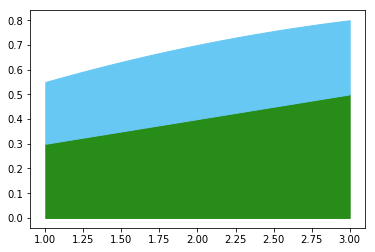

In [2]:
#Just draw clusters with size
CCF={0:[0.3,0.4,0.5],
     1:[0.25,0.3,0.3]} #Dictionary by cluster
make_fish(CCF)

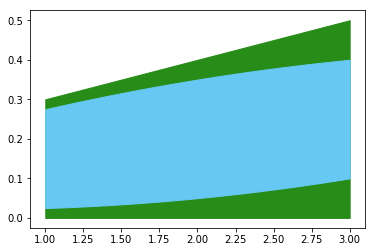

In [3]:
## Alternatively, we can build a phylogeny 
DG=nx.DiGraph() 
DG.add_edge(0,1) #use nx digraph

make_fish(CCF,graph=DG)

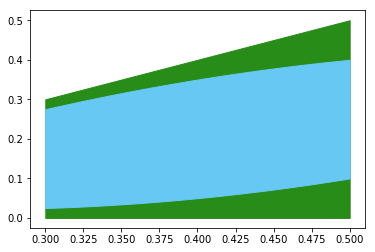

In [4]:
## Sepcfiy time
times=[0.3,0.4,0.5]
make_fish(CCF,graph=DG,times=times)


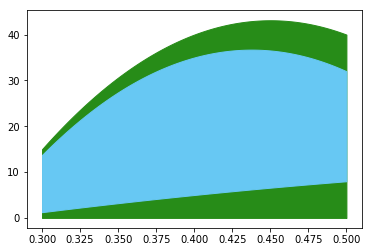

In [5]:
## Specify overall size
wbc=[50,100,80]
make_fish(CCF,graph=DG,times=times,wbc=wbc)

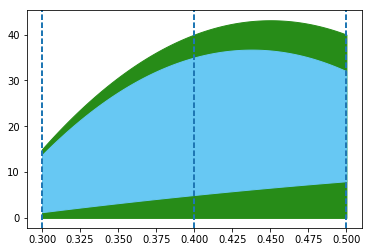

In [6]:
## Add lines at sample points
samples=["1","2","3"]
make_fish(CCF,graph=DG,times=times,wbc=wbc,sample_labels=samples)

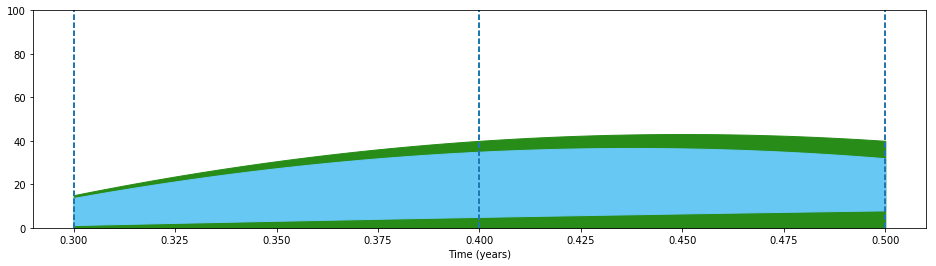

In [7]:
## Change anything 
plt.figure(figsize=(16,4))

make_fish(CCF,graph=DG,times=times,wbc=wbc,sample_labels=samples,interp="smooth")

plt.ylim(0,100)
plt.xlabel("Time (years)")


In [8]:
## to save just savefig as eps (svg works too but export is worse)

AttributeError: class simple_tree has no attribute '_xvals'

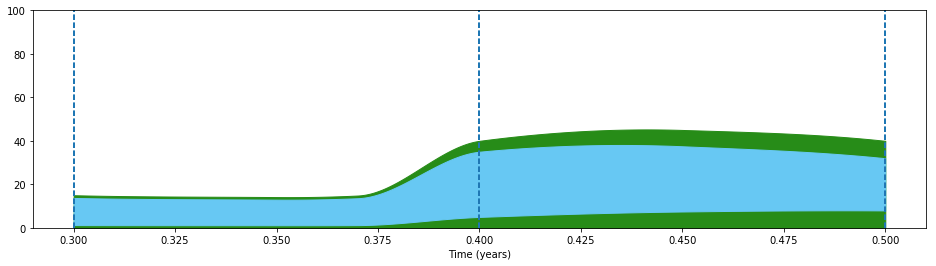

In [11]:
## add whitecounts
plt.figure(figsize=(16,4))

add_wbc=simple_tree(_xvals=[0.35,36,0.37,0.45],
                    _data=[45,55,50,100],
                    sorted_=False) 


make_fish(CCF,graph=DG,times=times,wbc=wbc,add_wbc=add_wbc,sample_labels=samples,interp="smooth",
          smooth_hack=True)  ### <-- if adding white count points that do not overlap the measured points, set this to True. 
plt.ylim(0,100)
plt.xlabel("Time (years)")
plt.scatter(simple_tree._xvals,simple_tree._data)


In [ ]:
import collections
def make_ccf_grid_from_sample(ccf_dat,n):
    variant_ccf_dict=collections.OrderedDict()
    sample=ccf_dat.sample_list[n]
    ccf_dict={x[0]+1:np.argmax(x[1][n])/100. for x in enumerate(sample.DPresults_ND["clust_CCF_dens"])}
    for variant in sample.concordant_variants:
        variant_ccf_dict[variant]=ccf_dict[variant.cluster_assignment]
    return variant_ccf_dict


In [ ]:
def make_scatter(ccf_dat):
    scatter_vals_x=[]
    scatter_vals_y=[]
    scatter_vals_c=[]
    scatter_vals_s=[]

    gene_headers=[]
    sample_headers=[]
    phylo_cmap=mcolors.ListedColormap(tableau40)


    for sample_idx in range(len(ccf_dat.sample_list)):
        mut_idx=0
        sample_headers.append(ccf_dat.sample_names[sample_idx])

        for cluster in reversed(range(1,max(ccf_dat.sample_list[0].DPresults_ND["assign"])+1)):
            cluster_muts=0
            for variant,ccf in make_ccf_grid_from_sample(ccf_dat,sample_idx).iteritems():
                if variant.cluster_assignment != cluster:continue

                if variant.gene not in plotter.driver_genes: continue
                if variant.mut_category == "Silent": continue
                

                scatter_vals_x.append(sample_idx+0.5)
                scatter_vals_y.append(mut_idx+0.5)
                scatter_vals_s.append(ccf)
                scatter_vals_c.append(cluster-1)
                mut_idx+=1
                if sample_idx==0:
                    gene_headers.append(str(variant)[:15])
                cluster_muts+=1
             
            for variant,ccf in make_ccf_grid_from_sample(ccf_dat,sample_idx).iteritems():
                if cluster_muts >= 3:continue
                    
                if variant.gene in plotter.driver_genes and  variant.mut_category != "Silent": continue
                if variant.cluster_assignment != cluster:continue
                

                scatter_vals_x.append(sample_idx+0.5)
                scatter_vals_y.append(mut_idx+0.5)
                scatter_vals_s.append(ccf)
                scatter_vals_c.append(cluster-1)
                mut_idx+=1
                if sample_idx==0:
                    gene_headers.append(str(variant)[:15])
                cluster_muts+=1

    scatter_matrix=zip(scatter_vals_x,scatter_vals_y,scatter_vals_c,scatter_vals_s)

    #plt.xticks([x+0.5 for x in range( len(plot_array[0]))],[header.keys()[x] for x in index_tumor],rotation=90)
    #plt.yticks([x+0.5 for x in range( len(plot_array))],[gene_headers.keys()[x] for x in reversed(index_gene)], fontsize=9, fontweight='bold')
    fig3 = plt.figure(figsize=[len(sample_headers)/2.+.5, len(gene_headers)/3.5+0.35])
    scatter_vals_s=np.array(scatter_vals_s)
    scatter_vals_s=scatter_vals_s/max(scatter_vals_s)

    plt.scatter(np.array(scatter_vals_x),np.array(scatter_vals_y),
                c=[phylo_cmap.colors[x] for x in scatter_vals_c],
                s=np.array(scatter_vals_s)*75,
                marker="s", 
                facecolors=True,
                edgecolor='none'
               )

    #plt.ylim(-0.1, max(scatter_vals_y)+0.1)
    #plt.xlim(-0.1,  max(scatter_vals_x)+0.1)

    plt.xticks([x+0.5 for x in range( len(sample_headers))],sample_headers,rotation=90, fontweight='bold')
    plt.yticks([x+0.5 for x in range( len(gene_headers))],gene_headers, fontsize=9, fontweight='bold')
    plt.gca().set_frame_on(0)


    return fig3


